In [1]:
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import networkx as nx
# import phate
import scvelo as scv

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import scipy.cluster.hierarchy
from scipy.spatial.distance import cdist, pdist, squareform
from scipy import ndimage
from scipy.sparse import csr_matrix
import scipy.stats
from sklearn.cluster import KMeans

from scanpy.tools._score_genes import score_genes

from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter

import sys
sys.path.append("../../lib")
from stpalette import palette1
from utils import loadCNVfromCaSpER, loadCNVfromInferCNV

import scFates as scf

from pathways import genesDicts

In [2]:
model = 'WM4237'

dataPath = '../../data/'
preprocessedCasperCNVDataPath = 'c:/Projects/A_ST/output_casper_%s/' % model
preprocessedInferCNVDataPath = 'c:/Projects/A_ST/inferCNV_results_%s/' % model

ids = sorted(np.loadtxt(dataPath + 'ids_%s_ST.txt' % model, dtype=str))
sids = [id[7:12] for id in ids]

palette1.update({sid: cm.terrain(0.01 + i/len(sids)) for i, sid in enumerate(sids)})

In [3]:
df_infercnv_cnv, df_infercnv_meta = loadCNVfromInferCNV(dataPath + 'For_inferCNV_%s_meta.data.tsv.gz' % model, 
                                                        [preprocessedInferCNVDataPath + 'infercnv.references.txt',
                                                         preprocessedInferCNVDataPath + 'infercnv.observations.txt'])

(8897, 18397) (18397, 3)


# Load ad_all

In [4]:
ad_all = sc.read(dataPath + 'ad_all_human_clustered_st_%s.h5ad' % model)
print(ad_all.shape)

preprocessedStDataPath = 'c:/Projects/A_ST/from HPCC 11 28 2022/results_NF1-nod-t2t-k35/%s/' % model
ads = {id: ad_all[ad_all.obs['sample']==id, :] for id in ids}
images = {id: sc.read(preprocessedStDataPath + '%s/st_adata_processed.h5ad' % id).uns['spatial'] for id in ids}
for sample in ids[:]:
    ads[sample] = ad_all[ad_all.obs['sample']==sample, :].copy()    
    ads[sample].uns['spatial'] = images[sample]

(18406, 18720)


# Least and most similar persisters

In [19]:
# Looking for subset of T0 which are similar to T1
df0 = df_infercnv_cnv.copy()
df0.columns = pd.MultiIndex.from_frame(df_infercnv_meta.loc[df_infercnv_cnv.columns].reset_index().rename({'index': 'spot'}, axis=1))
df1 = df0.groupby(level=['time', 'cluster'], axis=1).mean()[[('T1', '3'), ('T1', '4'), ('T1', '7'), ('T1', '8')]]
df0 = df0.xs('T0', level='time', axis=1)
print(df0.shape, df1.shape)

def tempf(cl):
    se = pd.DataFrame(index=df0.columns, columns=df1.columns, data=cdist(df0.values.T, df1.values.T, metric='correlation')).droplevel(0, axis=1)[cl].sort_values()
    top_most_similar_i_r = se[:200].index.get_level_values(0)
    top_least_similar_i_r = se[-200:].index.get_level_values(0)

    ni = 'sel_sim_i_r'
    ad_all.obs[ni] = 'other'
    ad_all.obs.loc[ad_all.obs.index.isin(top_most_similar_i_r), ni] = 'top_most_similar'
    ad_all.obs.loc[ad_all.obs.index.isin(top_least_similar_i_r), ni] = 'top_least_similar'

    return pd.crosstab(ad_all.obs[ad_all.obs['T']=='T0'][ni], ad_all.obs[ad_all.obs['T']=='T0']['cluster']).T.style.background_gradient(axis=0)

def tempf2(cl):
    se = pd.DataFrame(index=df0.columns, columns=df1.columns, data=cdist(df0.values.T, df1.values.T, metric='correlation')).droplevel(0, axis=1)[cl].sort_values()
    top_most_similar_i_r = se[:200].index.get_level_values(0)
    top_least_similar_i_r = se[-200:].index.get_level_values(0)
    return top_most_similar_i_r, top_least_similar_i_r

(8897, 4960) (8897, 4)


In [15]:
tempf('3')

sel_sim_i_r,other,top_least_similar,top_most_similar
cluster,,,
0,523,39,2
1,994,6,122
2,1485,32,65
5,379,9,9
6,1179,114,2


In [20]:
top_most_similar_i_r, top_least_similar_i_r = tempf2('7')
tempf('7')

sel_sim_i_r,other,top_least_similar,top_most_similar
cluster,,,
0,518,44,2
1,1024,8,90
2,1447,50,85
5,363,30,4
6,1208,68,19


In [22]:
palette1.update({'most similar': 'red', 'least similar': 'blue', 'other': 'grey'})

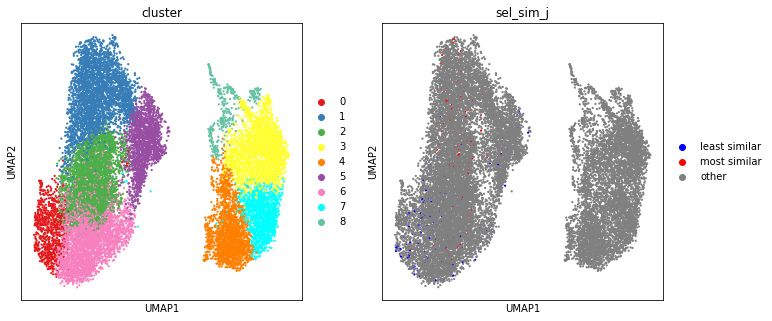

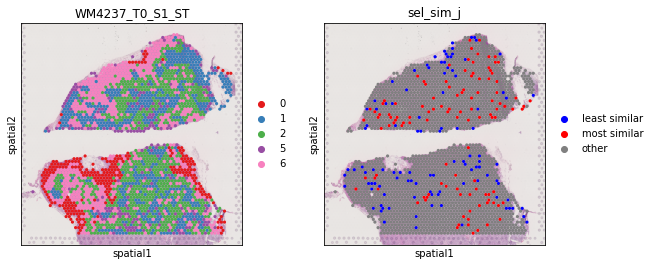

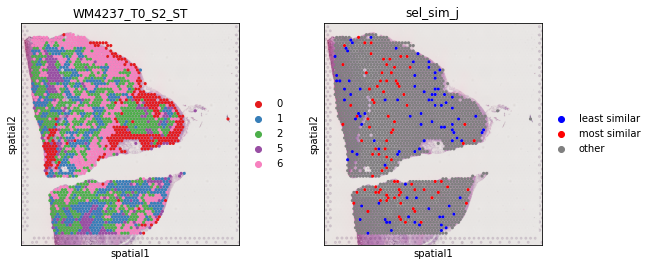

In [32]:
m = top_most_similar_i_r.copy()
ml = top_least_similar_i_r.copy()
ni = 'sel_sim_j'

ad_all.obs[ni] = 'other'
ad_all.obs.loc[ad_all.obs.index.isin(m), ni] = 'most similar'
ad_all.obs.loc[ad_all.obs.index.isin(ml), ni] = 'least similar'

plt.rcParams["figure.figsize"] = (5,5)
sc.pl.umap(ad_all, color=['cluster', ni], palette=palette1, size=20)

plt.rcParams["figure.figsize"] = (4,4)
for sample in ['WM4237_T0_S1_ST', 'WM4237_T0_S2_ST']:
    ads[sample] = ad_all[ad_all.obs['sample']==sample, :].copy()    
    ads[sample].uns['spatial'] = images[sample]
    sc.pl.spatial(ads[sample], color=['cluster', ni], palette=palette1, title=sample, spot_size=450)

# Pseudotime T0 axis on 0, 1 and 2

In [33]:
ad_sel = ad_all[ad_all.obs['T'].isin(['T0']) & ad_all.obs['cluster'].isin(['0', '1', '2', '5', '6'])].copy()
ad_sel = ad_sel[:, ad_sel.var['is_human_gene'].values]
sc.pp.highly_variable_genes(ad_sel, flavor="seurat", batch_key='sample', n_top_genes=200)
sc.pp.pca(ad_sel, n_comps=30, zero_center=True, use_highly_variable=True)
sce.pp.harmony_integrate(ad_sel, 'sample')
sc.pp.neighbors(ad_sel, use_rep='X_pca_harmony')
sc.tl.umap(ad_sel)

2023-03-17 13:05:33,951 - harmonypy - INFO - Iteration 1 of 10
2023-03-17 13:05:35,350 - harmonypy - INFO - Iteration 2 of 10
2023-03-17 13:05:36,745 - harmonypy - INFO - Iteration 3 of 10
2023-03-17 13:05:38,144 - harmonypy - INFO - Iteration 4 of 10
2023-03-17 13:05:39,536 - harmonypy - INFO - Iteration 5 of 10
2023-03-17 13:05:40,950 - harmonypy - INFO - Iteration 6 of 10
2023-03-17 13:05:42,072 - harmonypy - INFO - Iteration 7 of 10
2023-03-17 13:05:42,676 - harmonypy - INFO - Iteration 8 of 10
2023-03-17 13:05:43,191 - harmonypy - INFO - Converged after 8 iterations


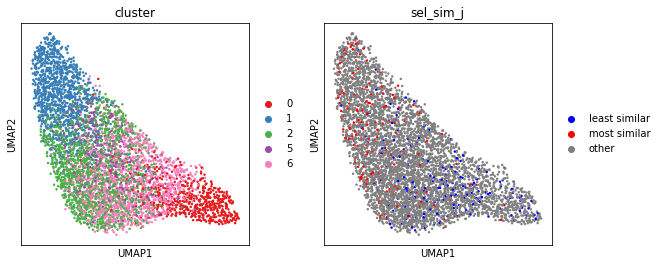

In [34]:
sc.pl.umap(ad_sel, color=['cluster', 'sel_sim_j'])

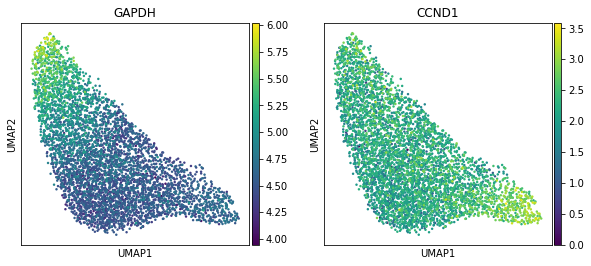

In [36]:
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.umap(ad_sel, color=['GAPDH', 'CCND1'])

# Pseudotime ordering

In [38]:
scf.tl.curve(ad_sel, Nodes=10, use_rep="X_umap", ndims_rep=2)

inferring a principal curve --> parameters used 
    10 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] hard assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


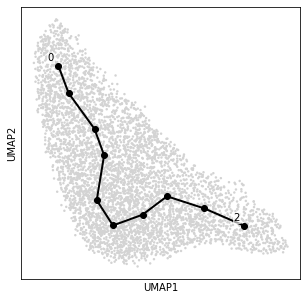

In [39]:
plt.rcParams["figure.figsize"] = (5,5)
scf.pl.graph(ad_sel, basis="umap")

In [40]:
scf.tl.root(ad_sel, 'GAPDH') 

automatic root selection using GAPDH values
node 0 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [41]:
scf.tl.convert_to_soft(ad_sel, 1, 1000)

Converting R into soft assignment matrix
    finished (0:00:00) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


In [42]:
scf.tl.pseudotime(ad_sel, n_jobs=6, n_map=100, seed=42)

projecting cells onto the principal graph
    mappings: 100%|██████████████████████████████████████████████████████████████████| 100/100 [05:13<00:00,  3.14s/it]
    finished (0:05:16) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


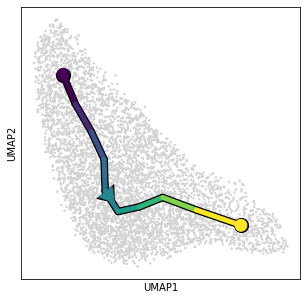

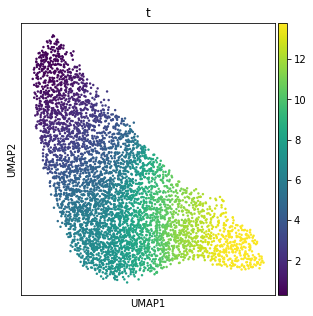

In [43]:
plt.rcParams["figure.figsize"] = (5,5)
scf.pl.trajectory(ad_sel, basis="umap", arrows=True, arrow_offset=1)
sc.pl.umap(ad_sel, color=['t'])

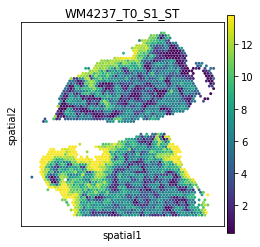

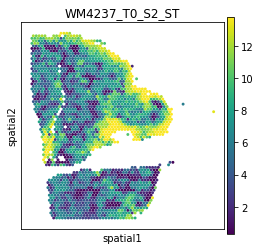

In [47]:
plt.rcParams["figure.figsize"] = (4,4)
for sample in ['WM4237_T0_S1_ST', 'WM4237_T0_S2_ST']:
    ad = ad_sel[ad_sel.obs['sample']==sample]
    sc.pl.spatial(ad, color=['t'], palette=palette1, title=sample, spot_size=450)

WM4237_T0_S1_ST
WM4237_T0_S2_ST


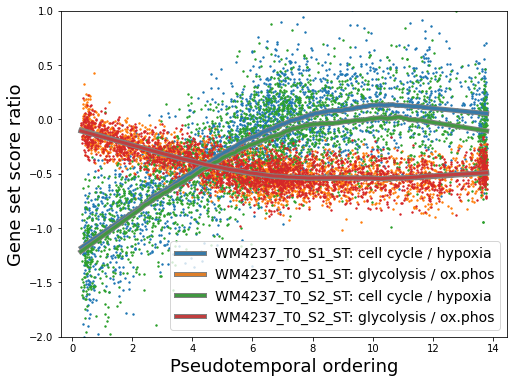

In [55]:
gene_list_names = ['WP_GLYCOLYSIS_AND_GLUCONEOGENESIS', 'CELL_CYCLE', 'OXPHOS', 'PID_HIF1_TFPATHWAY']

plt.rcParams["figure.figsize"] = (8,6)

for sample in ['WM4237_T0_S1_ST', 'WM4237_T0_S2_ST']:
    print(sample)
    ad = ad_sel[ad_sel.obs['sample']==sample].copy()
    for gene_list_name in gene_list_names:
        sn = 'score_%s' % gene_list_name
        if not sn in ad.obs.columns:
            score_genes(ad, gene_list=ad.var.index.intersection(genesDicts[gene_list_name]), score_name=sn, ctrl_size=50)
    
    def addScatterAndSpline(x, y, label=''):
        order = np.argsort(x)
        x, y = x[order], y[order]
        plt.scatter(x, y, s=2)
        
        xs = np.linspace(min(x), max(x), 1000)
        spline_data = np.vstack((xs, UnivariateSpline(x, y, k=1, s=10)(xs))).T
        sg = scipy.signal.savgol_filter(spline_data.T[1], 300, 1)
        plt.plot(spline_data.T[0], sg, lw=3, alpha=0.75,
                 path_effects=[path_effects.Stroke(linewidth=5, foreground='grey'), path_effects.Normal()],
                label=label)
        
        return
    
    ad.obs['score_CELL_CYCLE_over_PID_HIF1_TFPATHWAY'] = np.log(ad.obs['score_CELL_CYCLE'] / ad.obs['score_PID_HIF1_TFPATHWAY'])
    ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS_over_OXPHOS'] = np.log(ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS'] / ad.obs['score_OXPHOS'])
    
    addScatterAndSpline(ad.obs['t'], ad.obs['score_CELL_CYCLE_over_PID_HIF1_TFPATHWAY'], label=sample + ': cell cycle / hypoxia')
    addScatterAndSpline(ad.obs['t'], ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS_over_OXPHOS'], label=sample + ': glycolysis / ox.phos')
    
    plt.xlabel('Pseudotemporal ordering', fontsize=18)
    plt.ylabel('Gene set score ratio', fontsize=18)
    plt.ylim([-2,1])
    plt.legend(fontsize=14)

# Pseudotime T1

In [5]:
ad_sel = ad_all[ad_all.obs['T'].isin(['T1'])].copy()
ad_sel = ad_sel[:, ad_sel.var['is_human_gene'].values]
sc.pp.highly_variable_genes(ad_sel, flavor="seurat", batch_key='sample', n_top_genes=200)
sc.pp.pca(ad_sel, n_comps=30, zero_center=True, use_highly_variable=True)
sce.pp.harmony_integrate(ad_sel, 'sample')
sc.pp.neighbors(ad_sel, use_rep='X_pca_harmony')
sc.tl.umap(ad_sel)

2023-03-17 14:16:23,452 - harmonypy - INFO - Iteration 1 of 10
2023-03-17 14:16:23,504 - harmonypy - INFO - Iteration 2 of 10
2023-03-17 14:16:23,553 - harmonypy - INFO - Iteration 3 of 10
2023-03-17 14:16:23,604 - harmonypy - INFO - Iteration 4 of 10
2023-03-17 14:16:23,643 - harmonypy - INFO - Converged after 4 iterations


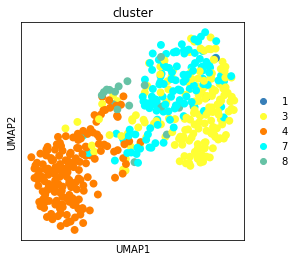

In [6]:
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.umap(ad_sel, color=['cluster'], palette=palette1) # , 'sel_sim_j'

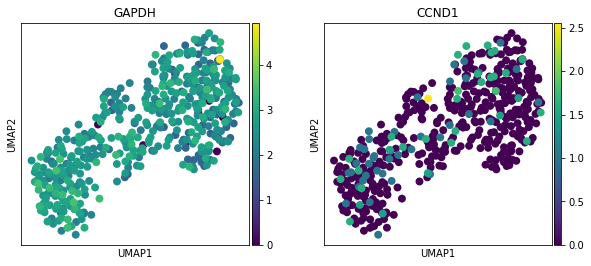

In [7]:
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.umap(ad_sel, color=['GAPDH', 'CCND1'])

inferring a principal curve --> parameters used 
    10 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] hard assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


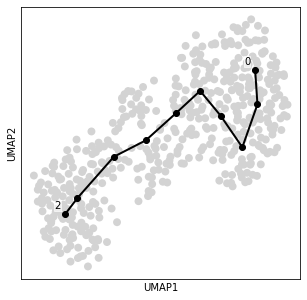

automatic root selection using GAPDH values
node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
Converting R into soft assignment matrix
    finished (0:00:00) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


In [8]:
scf.tl.curve(ad_sel, Nodes=10, use_rep="X_umap", ndims_rep=2)

plt.rcParams["figure.figsize"] = (5,5)
scf.pl.graph(ad_sel, basis="umap")

scf.tl.root(ad_sel, 'GAPDH') 

scf.tl.convert_to_soft(ad_sel, 1, 1000)

In [9]:
scf.tl.pseudotime(ad_sel, n_jobs=6, n_map=100, seed=42)

projecting cells onto the principal graph
    mappings: 100%|██████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]
    finished (0:02:00) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


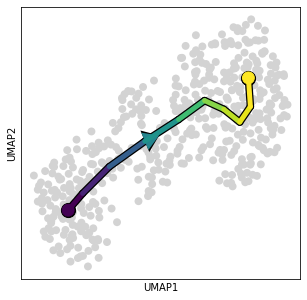

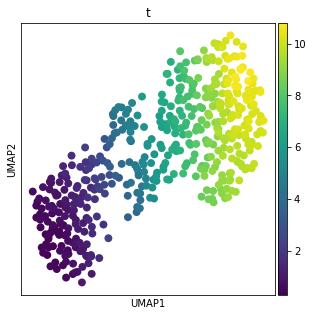

In [10]:
plt.rcParams["figure.figsize"] = (5,5)
scf.pl.trajectory(ad_sel, basis="umap", arrows=True, arrow_offset=1)
sc.pl.umap(ad_sel, color=['t'])

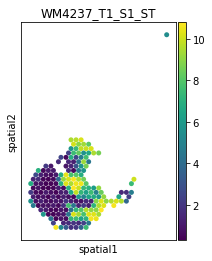

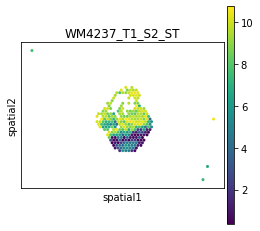

In [13]:
plt.rcParams["figure.figsize"] = (4,4)
for sample in ['WM4237_T1_S1_ST', 'WM4237_T1_S2_ST']:
    ad = ad_sel[ad_sel.obs['sample']==sample]
    sc.pl.spatial(ad, color=['t'], palette=palette1, title=sample, spot_size=450)

WM4237_T1_S1_ST
WM4237_T1_S2_ST


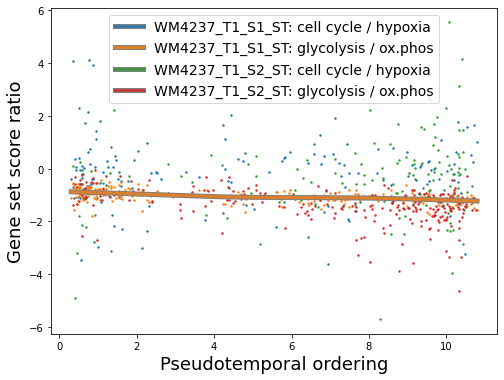

In [14]:
gene_list_names = ['WP_GLYCOLYSIS_AND_GLUCONEOGENESIS', 'CELL_CYCLE', 'OXPHOS', 'PID_HIF1_TFPATHWAY']

plt.rcParams["figure.figsize"] = (8,6)

for sample in ['WM4237_T1_S1_ST', 'WM4237_T1_S2_ST']:
    print(sample)
    ad = ad_sel[ad_sel.obs['sample']==sample].copy()
    for gene_list_name in gene_list_names:
        sn = 'score_%s' % gene_list_name
        if not sn in ad.obs.columns:
            score_genes(ad, gene_list=ad.var.index.intersection(genesDicts[gene_list_name]), score_name=sn, ctrl_size=50)
    
    def addScatterAndSpline(x, y, label=''):
        order = np.argsort(x)
        x, y = x[order], y[order]
        plt.scatter(x, y, s=2)
        
        xs = np.linspace(min(x), max(x), 1000)
        spline_data = np.vstack((xs, UnivariateSpline(x, y, k=1, s=10)(xs))).T
        sg = scipy.signal.savgol_filter(spline_data.T[1], 300, 1)
        plt.plot(spline_data.T[0], sg, lw=3, alpha=0.75,
                 path_effects=[path_effects.Stroke(linewidth=5, foreground='grey'), path_effects.Normal()],
                label=label)
        
        return
    
    ad.obs['score_CELL_CYCLE_over_PID_HIF1_TFPATHWAY'] = np.log(ad.obs['score_CELL_CYCLE'] / ad.obs['score_PID_HIF1_TFPATHWAY'])
    ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS_over_OXPHOS'] = np.log(ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS'] / ad.obs['score_OXPHOS'])
    
    addScatterAndSpline(ad.obs['t'], ad.obs['score_CELL_CYCLE_over_PID_HIF1_TFPATHWAY'], label=sample + ': cell cycle / hypoxia')
    addScatterAndSpline(ad.obs['t'], ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS_over_OXPHOS'], label=sample + ': glycolysis / ox.phos')
    
    plt.xlabel('Pseudotemporal ordering', fontsize=18)
    plt.ylabel('Gene set score ratio', fontsize=18)
#     plt.ylim([-2.5,1.5])
    plt.legend(fontsize=14)

# T4

In [5]:
ad_sel = ad_all[ad_all.obs['T'].isin(['T4'])].copy()
ad_sel = ad_sel[:, ad_sel.var['is_human_gene'].values]
sc.pp.highly_variable_genes(ad_sel, flavor="seurat", batch_key='sample', n_top_genes=200)
sc.pp.pca(ad_sel, n_comps=30, zero_center=True, use_highly_variable=True)
sce.pp.harmony_integrate(ad_sel, 'sample')
sc.pp.neighbors(ad_sel, use_rep='X_pca_harmony')
sc.tl.umap(ad_sel)

2023-03-24 15:22:55,839 - harmonypy - INFO - Iteration 1 of 10
2023-03-24 15:22:56,597 - harmonypy - INFO - Iteration 2 of 10
2023-03-24 15:22:57,347 - harmonypy - INFO - Iteration 3 of 10
2023-03-24 15:22:58,106 - harmonypy - INFO - Iteration 4 of 10
2023-03-24 15:22:58,548 - harmonypy - INFO - Iteration 5 of 10
2023-03-24 15:22:58,830 - harmonypy - INFO - Iteration 6 of 10
2023-03-24 15:22:59,112 - harmonypy - INFO - Converged after 6 iterations


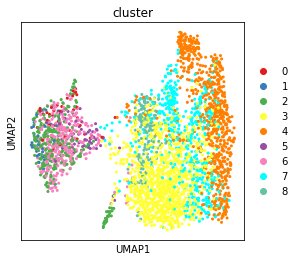

In [6]:
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.umap(ad_sel, color=['cluster'], palette=palette1) 

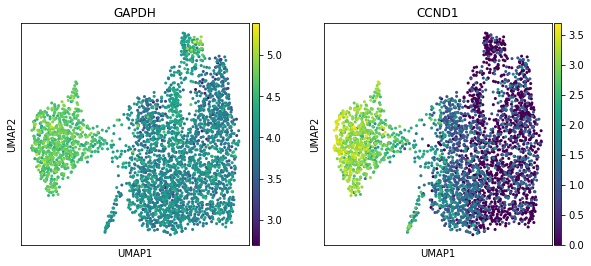

In [7]:
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.umap(ad_sel, color=['GAPDH', 'CCND1'])

inferring a principal curve --> parameters used 
    10 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] hard assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


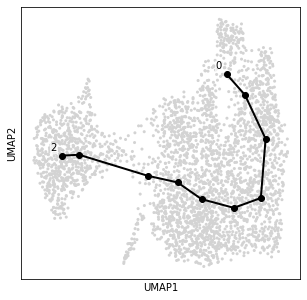

automatic root selection using GAPDH values
node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.
Converting R into soft assignment matrix
    finished (0:00:00) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


In [8]:
scf.tl.curve(ad_sel, Nodes=10, use_rep="X_umap", ndims_rep=2)

plt.rcParams["figure.figsize"] = (5,5)
scf.pl.graph(ad_sel, basis="umap")

scf.tl.root(ad_sel, 'GAPDH') 

scf.tl.convert_to_soft(ad_sel, 1, 1000)

In [9]:
scf.tl.pseudotime(ad_sel, n_jobs=6, n_map=100, seed=42)

projecting cells onto the principal graph
    mappings: 100%|██████████████████████████████████████████████████████████████████| 100/100 [04:05<00:00,  2.45s/it]
    finished (0:04:06) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


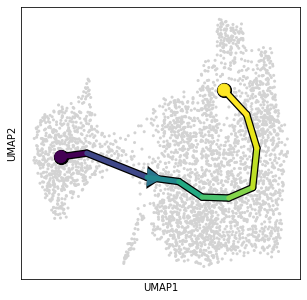

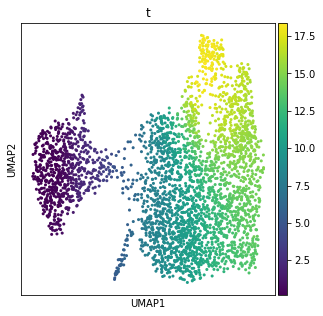

In [10]:
plt.rcParams["figure.figsize"] = (5,5)
scf.pl.trajectory(ad_sel, basis="umap", arrows=True, arrow_offset=1)
sc.pl.umap(ad_sel, color=['t'])

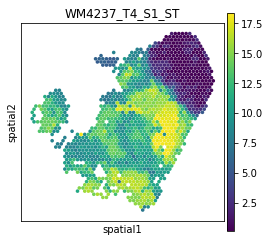

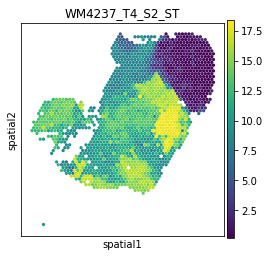

In [11]:
plt.rcParams["figure.figsize"] = (4,4)
for sample in ['WM4237_T4_S1_ST', 'WM4237_T4_S2_ST']:
    ad = ad_sel[ad_sel.obs['sample']==sample]
    sc.pl.spatial(ad, color=['t'], palette=palette1, title=sample, spot_size=450)

WM4237_T4_S1_ST
WM4237_T4_S2_ST


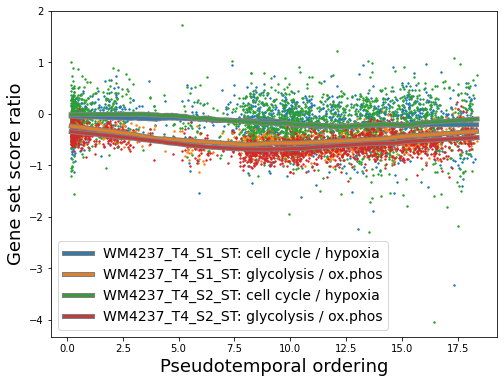

In [12]:
gene_list_names = ['WP_GLYCOLYSIS_AND_GLUCONEOGENESIS', 'CELL_CYCLE', 'OXPHOS', 'PID_HIF1_TFPATHWAY']

plt.rcParams["figure.figsize"] = (8,6)

for sample in ['WM4237_T4_S1_ST', 'WM4237_T4_S2_ST']:
    print(sample)
    ad = ad_sel[ad_sel.obs['sample']==sample].copy()
    for gene_list_name in gene_list_names:
        sn = 'score_%s' % gene_list_name
        if not sn in ad.obs.columns:
            score_genes(ad, gene_list=ad.var.index.intersection(genesDicts[gene_list_name]), score_name=sn, ctrl_size=50)
    
    def addScatterAndSpline(x, y, label=''):
        order = np.argsort(x)
        x, y = x[order], y[order]
        plt.scatter(x, y, s=2)
        
        xs = np.linspace(min(x), max(x), 1000)
        spline_data = np.vstack((xs, UnivariateSpline(x, y, k=1, s=10)(xs))).T
        sg = scipy.signal.savgol_filter(spline_data.T[1], 300, 1)
        plt.plot(spline_data.T[0], sg, lw=3, alpha=0.75,
                 path_effects=[path_effects.Stroke(linewidth=5, foreground='grey'), path_effects.Normal()],
                label=label)
        
        return
    
    ad.obs['score_CELL_CYCLE_over_PID_HIF1_TFPATHWAY'] = np.log(ad.obs['score_CELL_CYCLE'] / ad.obs['score_PID_HIF1_TFPATHWAY'])
    ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS_over_OXPHOS'] = np.log(ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS'] / ad.obs['score_OXPHOS'])
    
    addScatterAndSpline(ad.obs['t'], ad.obs['score_CELL_CYCLE_over_PID_HIF1_TFPATHWAY'], label=sample + ': cell cycle / hypoxia')
    addScatterAndSpline(ad.obs['t'], ad.obs['score_WP_GLYCOLYSIS_AND_GLUCONEOGENESIS_over_OXPHOS'], label=sample + ': glycolysis / ox.phos')
    
    plt.xlabel('Pseudotemporal ordering', fontsize=18)
    plt.ylabel('Gene set score ratio', fontsize=18)
#     plt.ylim([-2.5,1.5])
    plt.legend(fontsize=14)